PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
              ..
Cabin_F4       0
Cabin_G6       0
Cabin_T        0
Embarked_Q     0
Embarked_S     0
Length: 1726, dtype: int64
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores hiperparámetros:
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.8208955223880597
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86       157
           1       0.89      0.65      0.75       111

    accuracy                           0.82       268
   macro avg       0.84      0.80      0.81       268
weighted avg       0.83      0.82      0.81       268

Confusion Matrix:
 [[148   9]
 [ 39  72]]


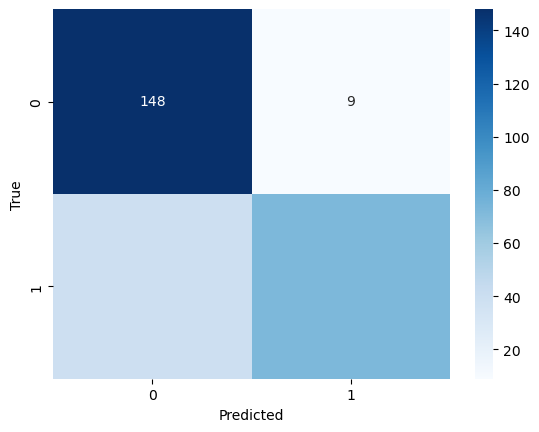

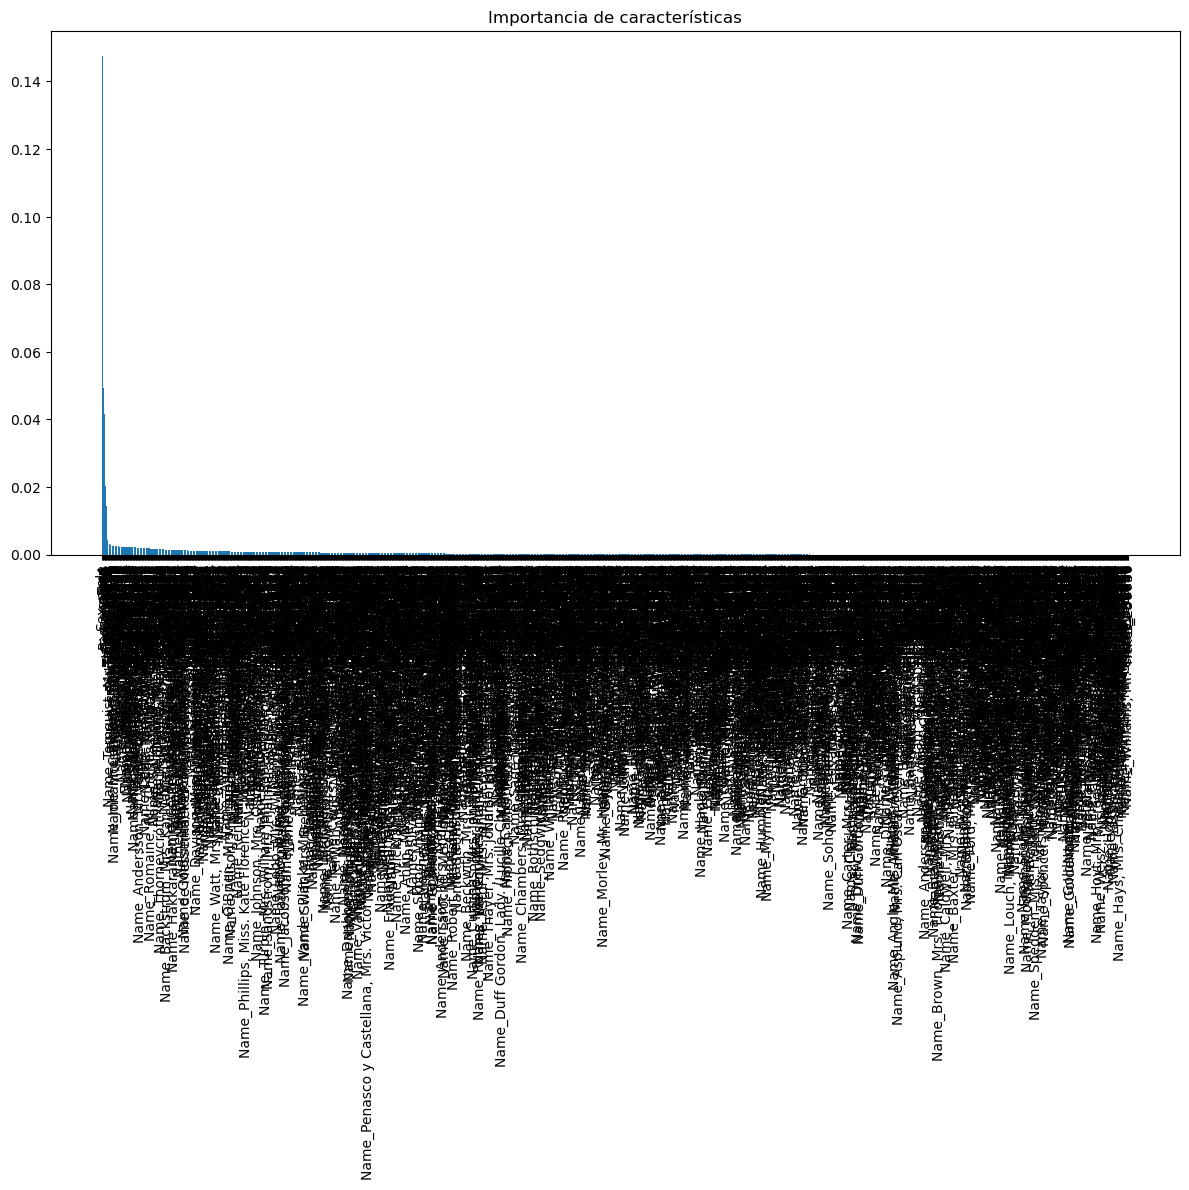

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
df = pd.read_csv(r"C:\Users\jengu\Titanic-Dataset.csv")

# Preprocesamiento del dataset
numeric_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(include=[object]).columns

# Imputar valores faltantes en columnas numéricas
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

# Codificar variables categóricas
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Verificar que no queden valores nulos
print(df.isnull().sum())

# Dividir el dataset en variables predictoras y objetivo
X = df.drop('Survived', axis=1)  # Reemplaza 'Survived' con el nombre correcto si es diferente
y = df['Survived']  # Reemplaza 'Survived' con el nombre correcto si es diferente

# Normalización de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Dividir el dataset en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Configuración de hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Búsqueda de la mejor combinación de hiperparámetros
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:\n", grid_search.best_params_)

# Predicciones en el conjunto de test
y_pred = best_model.predict(X_test)

# Evaluación del desempeño
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualización de la matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Importancia de características
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))  # Aumentar el tamaño de la figura
plt.title("Importancia de características")
plt.bar(range(X_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_scaled.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Ajustar margen inferior
plt.show()
